In [1]:
# !pip install PySastrawi
# !pip install wordcloud
# !pip install gensim
# nltk.download('stopwords')

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import string
import pickle

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split

In [10]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI

In [2]:
train_set_file = "dataset-idsa-master/labeled.csv"
df = pd.read_csv(train_set_file, sep = "\t")

In [3]:
train_set, test_set = train_test_split(df, test_size = 0.05, random_state = 0)
train_set = train_set.reset_index()
test_set = test_set.reset_index()
train_set.head()

,index,sentimen,Tweet
0,8892,0,aku kira kita telah berada di usia berkomitmen...
1,7885,0,untung kamu gak jd debut masuk pristin atau wj...
2,3681,1,ya tuhan kutuklah aku jadi milliader
3,8203,-1,leani ratri itu pernah mengaku ke media kalau ...
4,4763,1,aku pun geli juga kadang hose tu ada dalam lub...


In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

def cleansingTwit(kalimat):
    tokens = word_tokenize(kalimat)
    listStopword = set(stopwords.words('indonesian'))
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    def removeStopword(token):
        removed = []
        for t in tokens:
            if t not in listStopword:
                removed.append(t)
        return removed
    
    kalimat = kalimat.translate(str.maketrans('','', string.punctuation)).lower()
    kalimat = stemmer.stem(kalimat)
    tokens = removeStopword(tokens)
    return tokens

In [5]:
train_set['tidy_tweet'] = train_set['Tweet'].apply(cleansingTwit)
test_set['tidy_tweet'] = test_set['Tweet'].apply(cleansingTwit)

train_set.head()

,index,sentimen,Tweet,tidy_tweet
0,8892,0,aku kira kita telah berada di usia berkomitmen...,"[usia, berkomitmen, masanya, bilan]"
1,7885,0,untung kamu gak jd debut masuk pristin atau wj...,"[untung, gak, jd, debut, masuk, pristin, wjsn,..."
2,3681,1,ya tuhan kutuklah aku jadi milliader,"[ya, tuhan, kutuklah, milliader]"
3,8203,-1,leani ratri itu pernah mengaku ke media kalau ...,"[leani, ratri, mengaku, media, sedih, pertandi..."
4,4763,1,aku pun geli juga kadang hose tu ada dalam lub...,"[geli, kadang, hose, tu, lubang, jamban]"


In [17]:
def pandasToList(df, tidy_column):
    processedTweets = []
    for i in range(df.shape[0]):
        processedTweets.append((df.loc[i, tidy_column], df.loc[i, 'sentimen']))
    return processedTweets
    
def buildVocabulary(preprocessedTrainingData):
    all_words = []
    
    for (words, sentimen) in preprocessedTrainingData:
        all_words.extend(words)
    
    wordlist = nltk.FreqDist(all_words)
    wordlist_filter = lambda word_freq: dict( (word,word_freq[word]) for word in word_freq if word_freq[word]>1 )

    return list(wordlist_filter(wordlist).keys())[10:]

def extract_features(tweet):
    tweet_words = set(tweet)
    features={}
    for word in word_features:
        features['contains(%s)' % word] = (word in tweet_words)
    return features

def preprocessTwits(df, column):
    df['temp_'] = df[column].apply(cleansingTwit)
    return pandasToList(df, 'temp_')

filename = 'word_features.sav'
pickle.dump(preprocessTwits, open(filename, 'wb'))

In [7]:
processedTrainTweets = pandasToList(train_set)
processedTestTweets = pandasToList(test_set)

word_features = buildVocabulary(processedTrainTweets)
trainingFeatures = nltk.classify.apply_features(extract_features, processedTrainTweets)

In [19]:
features_file = 'word_features.sav'
pickle.dump(word_features, open(features_file, 'wb'))
len(word_features)

8842

In [9]:
def getAccuracy(classifier, preprocessed_testset, test_set):
    NBResultLabels = [classifier.classify(extract_features(tweet[0])) for tweet in preprocessed_testset]
    result = pd.Series(NBResultLabels) == test_set.sentimen
    return test_set[result].shape[0] / test_set.shape[0]

In [11]:
NBayesClassifier = nltk.NaiveBayesClassifier.train(trainingFeatures)
getAccuracy(NBayesClassifier, 
            processedTestTweets,
            test_set)

0.597132284921369

In [13]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(trainingFeatures)
getAccuracy(MNB_classifier, 
            processedTestTweets,
            test_set)

0.606845513413506

In [14]:
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(trainingFeatures)
getAccuracy(BNB_classifier, 
            processedTestTweets,
            test_set)

0.6022201665124884

In [27]:
LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(trainingFeatures)
getAccuracy(LogisticRegression_classifier, 
            processedTestTweets,
            test_set)

/Users/ilhamrizky/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6247689463955638

In [16]:
SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(trainingFeatures)
getAccuracy(SGDClassifier_classifier, 
            processedTestTweets,
            test_set)

0.6012950971322849

In [17]:
SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(trainingFeatures)
getAccuracy(SVC_classifier, 
            processedTestTweets,
            test_set)

0.6022201665124884

In [18]:
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(trainingFeatures)
getAccuracy(LinearSVC_classifier, 
            processedTestTweets,
            test_set)

0.5837187789084182

In [11]:
NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(trainingFeatures)
getAccuracy(NuSVC_classifier, 
            processedTestTweets,
            test_set)

0.6451016635859519

In [12]:
test_set['prediction'] = pd.Series([NuSVC_classifier.classify(extract_features(tweet[0])) for tweet in processedTestTweets])
test_set.head()

,index,sentimen,Tweet,tidy_tweet,prediction
0,10130,-1,hindari politisasi gempaulteng prabowo pilih g...,"[hindari, politisasi, gempaulteng, prabowo, pi...",0
1,8449,0,jika ditelusuri hingga ke hulu kedua air terju...,"[ditelusuri, hulu, air, terjun, giwe, marahai,...",0
2,5855,-1,setelah sy nonton g30s pki tdk ada manfaatnya ...,"[sy, nonton, g30s, pki, tdk, manfaatnya, rakya...",-1
3,7493,-1,anda fix saingan saya,"[fix, saingan]",0
4,1156,0,achie yg itu kan aunya doang serah serah aku d...,"[achie, yg, aunya, doang, serah, serah, lang, ...",0


In [15]:
import pickle
filename = 'nuSVC.sav'
pickle.dump(NuSVC_classifier, open(filename, 'wb'))

In [43]:
test_set['error'] = abs(test_set.sentimen - test_set.prediction)
print('rata-rata error', (test_set.error.mean() /2)* 100)

rata-rata error 20.42513863216266


In [44]:
test_set.sentimen.mean()

-0.059149722735674676

In [45]:
test_set.prediction.mean()

-0.08317929759704251

In [57]:
pd.crosstab(index = test_set.sentimen,
             columns = test_set.prediction)

prediction,-1,0,1
sentimen,,,
-1,67,69,8
0,38,228,19
1,16,47,49


In [53]:
from wordcloud import WordCloud
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800, height=500, background_color='grey', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

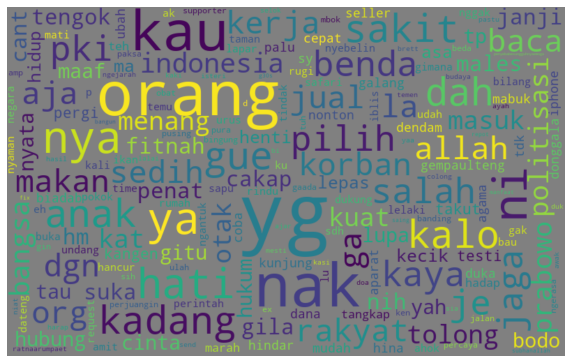

In [53]:
negas_tweets = test_set[test_set.sentimen == -1]
all_words = ' '.join([text for text in negas_tweets['tidy_tweet'].apply(lambda x: ' '.join(x))])
plot_wordCloud(all_words)

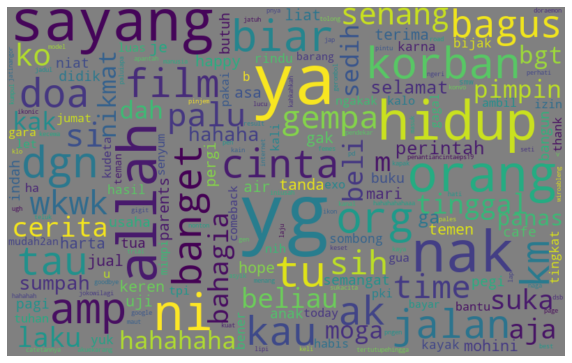

In [55]:
positive_tweets = test_set[test_set.sentimen == 1]
all_words = ' '.join([text for text in positive_tweets['tidy_tweet'].apply(lambda x: ' '.join(x))])
plot_wordCloud(all_words)

In [22]:
df = pd.read_pickle('all_mention.pkl')
df.head()

,id,date,content,replyCount,likeCount,quoteCount,sourceLabel,user_username,user_verified,user_created,user_followersCount,user_friendsCount,user_statusesCount,mentionedUsers_account,mentionedUsers_count,account,bank
1,1222787293951315969,2020-01-30 07:43:03+00:00,@promo_BRI Ratas saldo apaan min ??,1,0,0,Twitter for Android,Tenshi_Yeol,False,2010-09-29T09:56:22+00:00,203,55,49059,None,0,promo_bri,BRI
5,1222779502398332928,2020-01-30 07:12:06+00:00,BRI Setujui Restrukturisasi Utang Krakatau Ste...,0,0,0,Twitter Web App,KoranBUMN,False,2016-12-22T11:32:50+00:00,746,433,37476,"[kontakBRI, BANKBRI_ID, KemenBUMN, ojkindonesia]",4,promo_bri,BRI
7,1222745137475751937,2020-01-30 04:55:32+00:00,@promo_BRI min mau nge blokir atm hilang,3,0,0,Twitter for Android,Sayyaf12,False,2011-06-06T04:32:49+00:00,316,288,2898,None,0,promo_bri,BRI
8,1222699656813006848,2020-01-30 01:54:49+00:00,"@promo_BRI Min, kok Voucher nya belum diterima...",1,0,0,Twitter for Android,shandiroid,False,2010-02-06T04:42:16+00:00,200,337,2063,None,0,promo_bri,BRI
9,1222660135664766976,2020-01-29 23:17:46+00:00,"Lakukan Inovasi dan Digitalisasi Layanan, BRI ...",0,0,0,Twitter Web App,KoranBUMN,False,2016-12-22T11:32:50+00:00,746,433,37476,"[kontakBRI, BANKBRI_ID, ojkindonesia, KemenBUMN]",4,promo_bri,BRI


In [164]:
df_distinct = df\
    .groupby('id')\
    .mean()['user_followersCount']
df_content = df[['id', 'content']].drop_duplicates().set_index('id')

df_temp = df_content.join(df_distinct)\
    .groupby('content')\
    .agg(['count', 'sum'])\
    .reset_index()

df_temp1 = df_temp.user_followersCount
df_temp1['content'] = df_temp.content
df_temp1[df_temp1['count'] > 1 ].sort_values('sum').reset_index().loc[2,'content']

'@_ilhamprasetyaa @mandiricare Halo kak,Mohon maaf atas ketidaknyamanannya.\nUntuk informasi lebih lanjut silakan kakak hubungi Bank Mandiri\nLiveChat WhastApp klik dibawah ini\nhttps://t.co/NWb3EqpjAp\nTks ~firman'

In [ ]:
@_ilhamprasetyaa @mandiricare Halo kak,Mohon maaf atas ketidaknyamanannya.
Untuk informasi lebih lanjut silakan kakak hubungi Bank Mandiri
LiveChat WhastApp klik dibawah ini\nhttps://t.co/NWb3EqpjAp\nTks ~firman

In [48]:
405308-376794

28514

In [49]:
df.head()

,id,date,content,replyCount,likeCount,quoteCount,sourceLabel,user_username,user_verified,user_created,user_followersCount,user_friendsCount,user_statusesCount,mentionedUsers_account,mentionedUsers_count,account,bank
1,1222787293951315969,2020-01-30 07:43:03+00:00,@promo_BRI Ratas saldo apaan min ??,1,0,0,Twitter for Android,Tenshi_Yeol,False,2010-09-29T09:56:22+00:00,203,55,49059,None,0,promo_bri,BRI
5,1222779502398332928,2020-01-30 07:12:06+00:00,BRI Setujui Restrukturisasi Utang Krakatau Ste...,0,0,0,Twitter Web App,KoranBUMN,False,2016-12-22T11:32:50+00:00,746,433,37476,"[kontakBRI, BANKBRI_ID, KemenBUMN, ojkindonesia]",4,promo_bri,BRI
7,1222745137475751937,2020-01-30 04:55:32+00:00,@promo_BRI min mau nge blokir atm hilang,3,0,0,Twitter for Android,Sayyaf12,False,2011-06-06T04:32:49+00:00,316,288,2898,None,0,promo_bri,BRI
8,1222699656813006848,2020-01-30 01:54:49+00:00,"@promo_BRI Min, kok Voucher nya belum diterima...",1,0,0,Twitter for Android,shandiroid,False,2010-02-06T04:42:16+00:00,200,337,2063,None,0,promo_bri,BRI
9,1222660135664766976,2020-01-29 23:17:46+00:00,"Lakukan Inovasi dan Digitalisasi Layanan, BRI ...",0,0,0,Twitter Web App,KoranBUMN,False,2016-12-22T11:32:50+00:00,746,433,37476,"[kontakBRI, BANKBRI_ID, ojkindonesia, KemenBUMN]",4,promo_bri,BRI


In [168]:
a = set(stopwords.words('indonesian'))
print(len(a))
a.add('yg')
print(len(a))

757
758
